In [1]:
# %matplotlib inline
import numpy as np
import cv2 as cv
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
DEBUG = 0
win = 100
kernel_size = 9
Hist = np.zeros(256).reshape(256, 1)

In [3]:
def win_init():
    cv.namedWindow('img', cv.WINDOW_NORMAL)
    #cv.resizeWindow('img', 400, 400)
    cv.namedWindow('th', cv.WINDOW_NORMAL) 
    #cv.resizeWindow('th', 400, 400)
    cv.namedWindow('draw', cv.WINDOW_NORMAL)
    #cv.resizeWindow('draw', 400, 400)
def lst_square(points):
    """
        最小二乘法
        公式：inv(x.T * x) * x.T * Y
        备注：方向水平和方向竖直大致分两种情况计算，不然方向竖直时精度很低
    """
    
    dx = np.ptp(points[1])
    dy = np.ptp(points[0])
    # print(dx, dy)
    if dx > dy:
        x = np.ones((points[1].size, 2))
        x[:, 0] = points[1]
        # y = 99 - points[0].reshape(points[0].size, 1)
        y = points[0].reshape(points[0].size, 1)
        return np.linalg.inv(np.dot(x.T, x)).dot(x.T).dot(y)
    else:
        x = np.ones((points[0].size, 2))
        x[:, 0] = points[0]
        y = points[1].reshape(points[1].size, 1)
        temp = np.linalg.inv(np.dot(x.T, x)).dot(x.T).dot(y)
        # print(temp)
        return [1 / temp[0], - temp[1] / temp[0]]
        # return [1 / temp[0], - temp[1] / temp[0]]
    
def draw(img, theta):
    """
        画拟合线
    """
    x = np.linspace(0, 99, 100).astype(np.int64)
    y = np.floor(theta[0] * x + theta[1]).astype(np.int64)
    img[99 - y[np.where((y > 0) &(y < 100))], x[np.where((y > 0) &(y < 100))]] = 150 
    
def threshold(img):
    """
        阈值化
        方法：根据灰度分布直方图，找到窗口中最亮的若干点
    """
    hist = cv.calcHist([img],[0],None,[256],[0,256])
    cnt = 0
    th = 0
    for k in range(256):
        cnt = cnt + hist[255 - k]
        if cnt > 20:
            th = 255 - k - 1
            break
    ret, thImg = cv.threshold(img,th,255,cv.THRESH_BINARY)
    return thImg

def collinear_rate(points, theta):
    """
        计算窗口中点的线性度，越小表示越呈直线分布
    """
    div = np.linalg.norm([theta[0], 1])
    D = np.abs(theta[0] * points[1] - points[0] + theta[1])
    
    ret = np.mean(D / div)
    return ret
    

In [4]:
def Direction_estimate(image):
    """
        动态星图的方法估计，目前估计精度约小于1°,精度和时间上还有优化空间
    """
    row, col = image.shape
    blurImg = cv.GaussianBlur(image, (3, 3), 0)
    Theta = list([])
    
    for i in range(row // win):
        for j in range(col // win):
            drawImg = np.zeros((100, 100))
            window = blurImg[i * win : (i + 1) * win, j * win : (j + 1) * win]
            mean = np.mean(window)
            std = np.std(window)
            if mean > 180:
                continue
            thImg = threshold(window)
            points = np.array(np.where(thImg == 255))
            # 1. del outlier
            mean_x = int(np.mean(points[1]))
            mean_y = int(np.mean(points[0]))
            thImg[mean_y, mean_x] = 100
            dx = np.abs(points[1] - mean_x)
            dy = np.abs(points[0] - mean_y)
            points = points[:, np.where(dx + dy < 50)].reshape(2, -1)
            if points[0].size < 2:
                continue
            mean_x = int(np.mean(points[1]))
            mean_y = int(np.mean(points[0]))
            thImg[mean_y, mean_x] = 100
            dx = np.abs(points[1] - mean_x)
            dy = np.abs(points[0] - mean_y)
            points = points[:, np.where(dx + dy < 30)]
            if points[0].size < 2:
                continue
            # 2. Check for discreteness
            std_x = np.std(points[1])
            std_y = np.std(points[0])
        
            if std_x + std_y > 30 or std_x * std_y > 50:
                continue
            # print(points)
            # print(std_x + std_y, '   ', std_x * std_y)
            
            # 3. least square fit
            if points[0].size < 10:
                continue
            # print(points.shape)
            points[0] = 99 - points[0]
            theta = lst_square(points)
            
            # 4. Check for linearity
            nonlinear = collinear_rate(points, theta)
            if nonlinear > 0.8:
                continue
            # print(nonlinear)
            
            if DEBUG:
                draw(drawImg, theta)
                cv.imshow('img', window)
                cv.imshow('th', thImg)
                cv.imshow('draw', drawImg)
                print('a = ', theta[0], 'b = ', theta[1])
                print('---------------------------------------')
                key = cv.waitKey(0)
            else:
                key = cv.waitKey(1)
                
            # 5. Add theta to Theta
            theta = np.arctan(theta[0]) * 180 / np.pi
            Theta.append(theta)
            # print(theta[0])
                        
            
            if key == 27:
                cv.destroyAllWindows()
                return
    # 7. del outlier
    Theta.sort()
    std = np.std(Theta)
    while std > 0.6:
        a = Theta[1:]
        b = Theta[:-1]
        Theta = a if np.std(a) < np.std(b) else b
        std = np.std(Theta)
    if len(Theta) > 0:
        print('theta:', np.mean(Theta))
        if DEBUG:
            print('Theta:', Theta)
    return np.mean(Theta)
    cv.destroyAllWindows()

In [5]:
def Kernel(size, width, theta):
    """
        构造卷积核
        
    参数：size：卷积核尺寸
          width：正区域宽度
          theta：角度
    注：(size - width)最好是偶数，以使得卷积核对称
    """
    temp = np.zeros((size + 10,size + 10))
    temp [(size - width) // 2 + 5:(size - width) // 2 + 5 + width,:] = 1
    temp = Image.fromarray(temp)
    temp = temp.rotate(theta)
    temp = np.array(temp)
    kernel = temp[5:-5, 5:-5]
    cnt = np.sum(kernel)
    print(cnt)
    for i in range(size):
        for j in range(size):
            kernel[i, j] = cnt / (cnt - size * size) if kernel[i, j] == 0 else kernel[i, j]
    kernel = kernel / 4
    return kernel

In [36]:
def adaTh(img):
    img = cv.medianBlur(img, 5)
    img1 = img.copy()
    # plt.figure()
    # plt.imshow(img[30:70, 30:70], cmap = 'gray')

    for i in range(6, img.shape[0] - 6):
        for j in range(6, img.shape[1] - 6):
            kernel = img[i - 5: i + 5, j - 5:j + 5]
            s = np.sort(kernel.flatten())
            img1[i, j] = np.mean(s[:50])

    img_diff = img.astype(np.short) - img1.astype(np.short)
    for i in range(img_diff.shape[0]):
        for j in range(img_diff.shape[1]):
            if img_diff[i, j] < 12:
                img_diff[i, j] = 0
            else:
                img_diff[i, j] = 255
    img_diff = img_diff.astype(np.uint8)
    return img_diff

theta: -27.1917447048
39.0


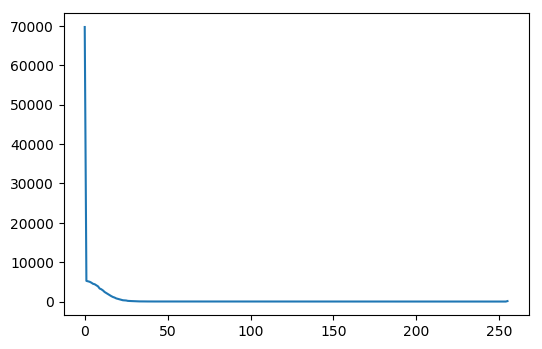

291


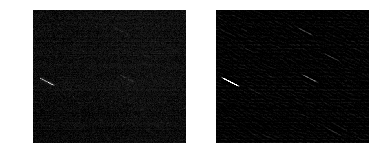

In [46]:
"""
    计算角度、阈值化、划分轮廓
"""
DEBUG = 0
plt.figure(dpi = 200)
read = cv.imread('-27_crop.png')
src = cv.cvtColor(read, cv.COLOR_BGR2GRAY);
if DEBUG:
    win_init()
theta = Direction_estimate(src)
# print(Th, 'Th:',np.mean(Th))
kernel = Kernel(11, 3, theta)
# plt.imshow(kernel, cmap = 'gray')
ret = cv.filter2D(src, -1, kernel)

Hist = cv.calcHist([ret],[0],None,[256],[0,256])
num = Hist.sum() * 0.0625
cnt = 0
for k in range(256):
    cnt = cnt + Hist[255 - k]
    if cnt > num:
        th = 255 - k - 1
        break

r, thImg = cv.threshold(ret, th,255,cv.THRESH_BINARY)
# thImg = adaTh(ret)

plt.figure(dpi = 100)
plt.plot(Hist)
plt.show()

cv.imshow('draw', src)
cv.waitKey(1)
cv.imshow('img', ret)
cv.waitKey(1)
cv.imshow('th', thImg)
cv.waitKey(0)

thImg[-5:,] = 0
cv.imwrite('thImg2.png', thImg)
cv.imwrite('filtedImg.png', ret)


k = cv.getStructuringElement(cv.MORPH_RECT, (2, 2))
thImg = cv.morphologyEx(thImg, cv.MORPH_OPEN, k)
cv.imshow('th', thImg)
cv.imwrite('thImg1.png', thImg)
cv.waitKey(0)




contours, hierarchy = cv.findContours(thImg,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_NONE) 
# cv2.drawContours(thimg,contours,-1,(0,0,255),3) 
print(len(contours))



plt.figure()
plt.subplot(121)
plt.imshow(src, cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(ret, cmap = 'gray')
plt.axis('off')
plt.show()
cv.destroyAllWindows()

In [39]:
r = np.array([[np.cos(theta * np.pi / 180), -np.sin(theta * np.pi / 180)], # 旋转矩阵
                [np.sin(theta * np.pi / 180), np.cos(theta * np.pi / 180)]])
class AnalysedContour(object):
    
    def __init__(self, contour, r):
        self.data = contour.squeeze(1) if len(contour.shape) == 3 else contour
        self.area = cv.contourArea(contour)
        M = r.dot(self.data.transpose()).transpose()
        self.l = np.min(M[:, 0])
        self.r = np.max(M[:, 0])
        self.d = np.min(M[:, 1])
        self.u = np.max(M[:, 1])
        self.w = self.r - self.l
        self.h = self.u - self.d
        self.cx = np.mean(M[:, 0])
        self.cy = np.mean(M[:, 1])
        
def analysed(contour):
    """
        分析一个contour的信息，包括：长、宽、面积等
    """
    global r
    M = r.dot(contour.squeeze(1).transpose()).transpose()
    w = np.ptp(M[:, 0])
    h = np.ptp(M[:, 1])
    s = cv.contourArea(contour)
    
    
    if(aMin < bMax):
        gap = bMin - aMax
    else:
        gap =  aMin - bMax
    d1 = np.abs(aMax + bMax - aMin - bMin) / 2
    d2 = np.abs(np.mean(M1[:, 1]) - np.mean(M2[:, 1]))
    

def distance(A, B):
    """
        分析两个contour的距离信息
        返回值：d1 ：两个contour的中点距离
                d2 ：两个contour的线距
                gap ：两个contour之间的断裂的距离
    """
    aMin, aMax, bMin, bMax = A.l, A.r, B.l, B.r
    ac, bc = A.cy, B.cy
    if(aMin < bMax):
        gap = bMin - aMax
    else:
        gap =  aMin - bMax
    d1 = np.abs(aMax + bMax - aMin - bMin) / 2
    d2 = np.abs(ac - bc)
    return d1, d2, gap
def contourLen(A):
    global r
    M = A.squeeze(1)
    # print(M.shape)
    xLen = np.abs(np.ptp(M[:, 0]))
    yLen = np.abs(np.ptp(M[:, 1]))
    return np.linalg.norm((xLen, yLen))
def merge(contour_list, index):
    """
        将若干个contour合并（将断裂的星点连接起来）
    """
    global r
    index = list(index)
    totalLen = 0
    for i in range(len(index)):
        totalLen = totalLen + contour_list[index[i]].w
    print('Before merge:', [contour_list[index[i]].w for i in range(len(index))])
    # print(index)
    
    for i in range(1, len(index)):
        contour_list[index[0]].data = np.concatenate((contour_list[index[0]].data, contour_list[index[i]].data), axis = 0)
        contour_list[index[i]].w = 0
    contour_list[index[0]] = AnalysedContour(contour_list[index[0]].data, r)
    Len = contour_list[index[0]].w
    if len(index) == 2 and totalLen / Len < 0.6:
        contour_list[index[0]].w = 0
    elif len(index) == 3 and totalLen / Len < 0.7:
        contour_list[index[0]].w = 0
    else:
        print('After merge:', [contour_list[index[i]].w for i in range(len(index))])
        pass
    return contour_list
def drawContour(cImg, star_contour):
    for contour in star_contour:
        cImg[[contour.data[:, 1], contour.data[:, 0]]] = 255
def show_contours(contour_list):
    cv.namedWindow('contours', cv.WINDOW_NORMAL)
    # cv.resizeWindow('img', cImg., 400)
    contourImg = np.zeros_like(read)
    # ret = cv.drawContours(cImg,star_contour,-1,(255,255,255),1)
    ret = drawContour(contourImg, contour_list)
    cv.imshow('contours', contourImg)
    cv.imwrite('contours.png', contourImg)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [40]:
contour_list = []
for contour in contours:
    # print(cv.contourArea(contour), contour.shape[0])
    if cv.contourArea(contour) > 5  and contour.shape[0] > 20:
        contour_list.append(AnalysedContour(contour, r))

contour_list.sort(key = lambda contour: contour.cy)
show_contours(contour_list)

table = list(np.ones(len(contour_list)) * 9999)
llist = []
for i in range(len(contour_list)):
    llist.append(set())
for i in range(len(contour_list)):
    if(table[i] == 9999):
        table[i] = i
    for j in range(i + 1, len(contour_list)):
        d1, d2, gap = distance(contour_list[i], contour_list[j])
        # print(i, j, d1, d2, gap)
        if d2 > 1: # 线距离大于5，直接退出循环
            break
        else:
            # print(i, j, d1)
            #if d1 > 10 and d1 < 100 and gap < 40:
            if d1 > 5 and d1 < 50 and gap < 40:
                if table[j] == 9999:
                    table[j] = table[i]
                    llist[table[i]].add(j)
                else:
                    table[i] = table[j]
                    llist[table[j]].add(i)
                # print(i, j, d1)
            else:
                continue
                
for i in range(len(llist)):
    if len(llist[i]) > 0 and len(llist[i]) < 3: # 顶多拼三段
        llist[i].add(i)
        contour_list = merge(contour_list, llist[i])
        
star_contour = []
maxLen = 0
for i in contour_list:
    if i.w == 0:
        continue
    if  i.w > maxLen and i.w < 500:
        maxLen = i.w
print(maxLen)
for i in contour_list:
    if i.w == 0:
        continue
    if  i.w > maxLen * 0.6:
        star_contour.append(i)
print('maxLen', maxLen,'num:', len(star_contour))

Before merge: [11.635302493138624, 17.43234678833619]
After merge: [37.12127354969607, 0]
Before merge: [9.8341599049939532, 12.070132926646011]
After merge: [31.303622303126758, 0]
Before merge: [14.306105948297841, 23.705435419784635]
After merge: [40.702951774613439, 0]
Before merge: [21.924899783011824, 11.635302493138624]
After merge: [41.613826544371705, 0]
Before merge: [10.724427723380472, 21.014025013253558]
After merge: [44.71946043303808, 0]
52.3382542678
maxLen 52.3382542678 num: 31


In [41]:
"""
    画图
"""
cImg = np.zeros_like(read)
# ret = cv.drawContours(cImg,star_contour,-1,(255,255,255),1)
ret = drawContour(cImg, star_contour)

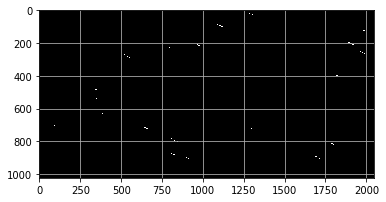

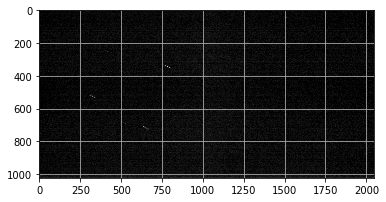

In [42]:
"""
    结果显示
"""
cv.namedWindow('0', cv.WINDOW_NORMAL)
# cv.resizeWindow('img', cImg., 400)
cv.imshow('0', thImg)
cv.waitKey(1)
cv.namedWindow('1', cv.WINDOW_NORMAL)
# cv.resizeWindow('img', cImg., 400)
cv.imshow('1', src)
cv.waitKey(1)
cv.namedWindow('2', cv.WINDOW_NORMAL)
cv.imwrite('2.png', cImg)
# cv.resizeWindow('img', cImg., 400)
cv.imshow('2', cImg)
cv.waitKey(0)
cv.destroyAllWindows()
plt.figure()
plt.grid('on')
plt.imshow(cImg)
plt.show()
plt.figure()
plt.grid('on')
plt.imshow(src, cmap = 'gray')
plt.show()